# Problem 1: Random Walk Monte Carlo

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

Write your own Random Walk MCMC algorithm from scratch. Don't worry if it is slow or inefficient - this exercise is about intuition building, not results. Use your sampler to fit a line to the data and generate samples from the posterior. For a first pass, run the sampler for a fixed number of steps, $N$. Then, modify the sampler to automatically stop running when a target number of effective samples $N_{\rm eff}$ has been reached.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('line_fitting.csv')
data = data[['x', 'y', 'y_err']]
data.head()
x = data['x']
y = data['y']
y_err = data['y_err']

Text(0, 0.5, 'y')

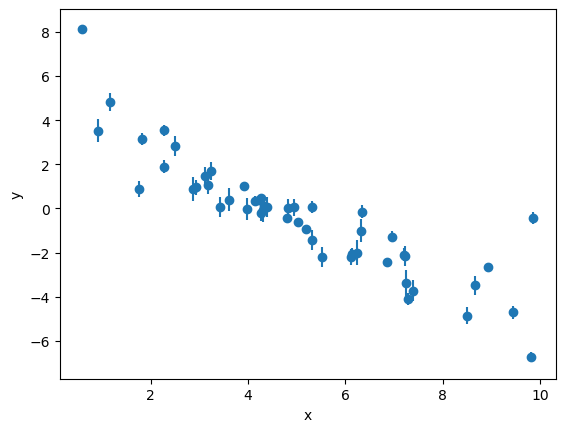

In [3]:
plt.errorbar(x, y, y_err, fmt = 'o')
plt.xlabel('x')
plt.ylabel('y')

# Problem 2: Fitting a Line

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

a) Fit the data using an ensemble sampler of your choice (recommendation: `emcee`)

b) Fit the data using a Hamiltonian Monte Carlo Sampler of your choice (recommendation: `PyMC` or `NumPyro`)

c) Fit the data using a nested sampler of your choice (recommendation: `dynesty`, `UltraNest`)

For all three cases, explicity write down the likelihood function; the `emcee` documentation has a clear explanation of how to do this. For Nested Sampling, you will also need to write a prior transform function; the `dynesty` documentation has a clear explanation of how to do this. Play around with using different priors (e.g. Gaussian, Uniform, Log-Uniform) to get a feel for the syntax of the different packages.

In [4]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = -0.737
b = 2.696
f = 1.280


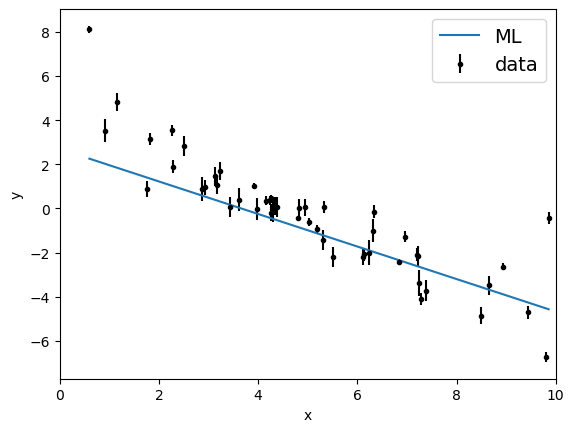

In [11]:
from scipy.optimize import minimize
np.random.seed(42)

m_guess = -1
b_guess = 6
f_guess = 0.5

nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_guess, b_guess, np.log(f_guess)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, y_err))
m_ml, b_ml, log_f_ml = soln.x

y_model = m_ml * x + b_ml

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=y_err, fmt=".k", capsize=0, label = 'data')

#plt.plot(x0, m_guess * x0 + b_guess, "k", alpha=0.3, lw=3, label="truth")
#plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
#plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.plot(x, y_model, label = 'ML')
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [12]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [13]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [14]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, y_err)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:35<00:00, 139.27it/s]


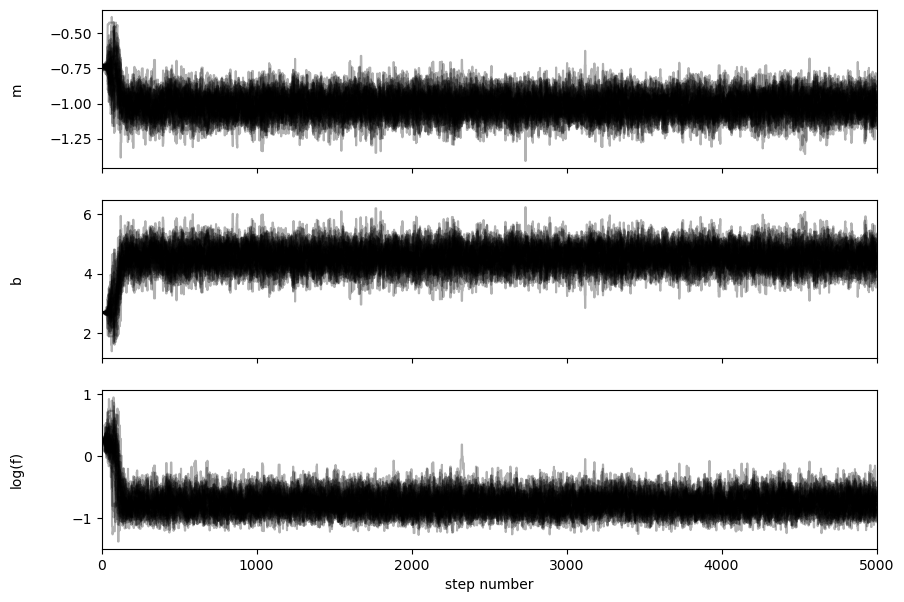

In [15]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [16]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


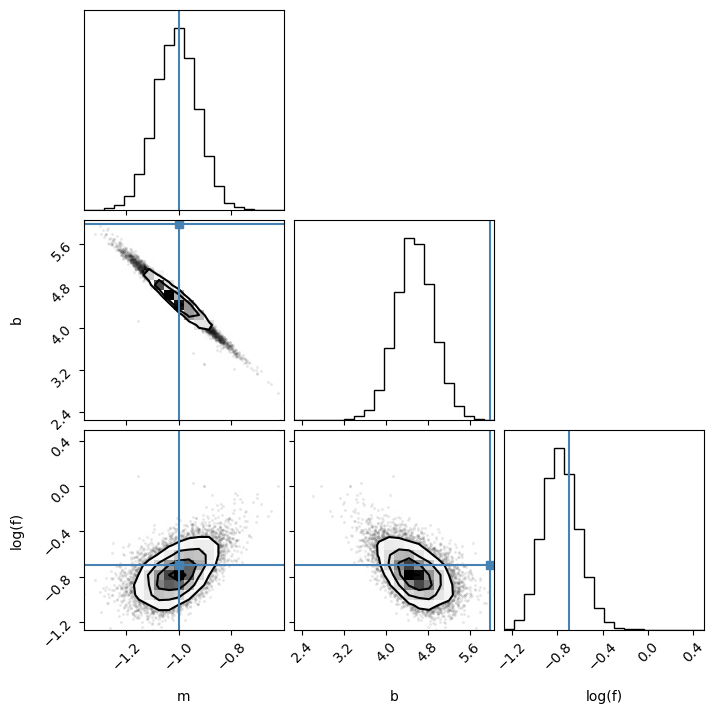

In [18]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_guess, b_guess, np.log(f_guess)]
);

In [23]:
sample[:2]

array([-0.93288858,  4.17224204])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


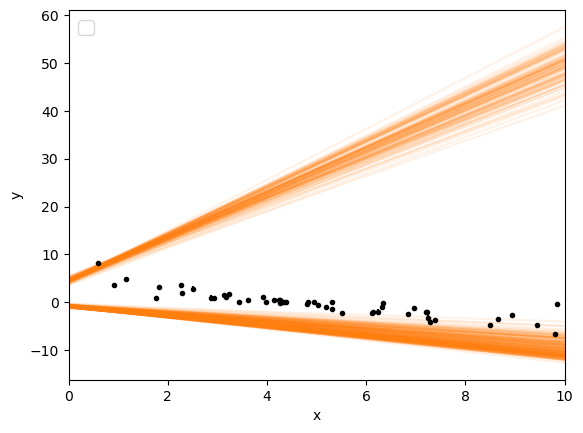

In [25]:
x0 = np.linspace(0, 10, 500)
inds = np.random.randint(len(samples), size=100)
for ind in inds:
    #sample = flat_samples[ind]
    sample = samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=y_err, fmt=".k", capsize=0)
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [27]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Dynasty


In [28]:
# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
rstate= np.random.default_rng(56101)

In [29]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [30]:
import dynesty

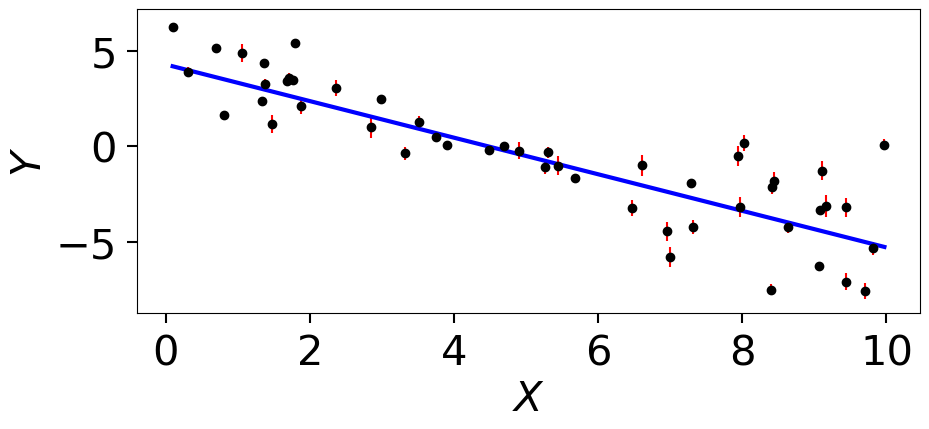

In [31]:
# truth
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# generate mock data
N = 50
x = np.sort(10 * rstate.uniform(size=N))
yerr = 0.1 + 0.5 * rstate.uniform(size=N)
y_true = m_true * x + b_true
y = y_true + np.abs(f_true * y_true) * rstate.normal(size=N)
y += yerr * rstate.normal(size=N)

# plot results
plt.figure(figsize=(10, 5))
plt.errorbar(x, y, yerr=yerr, fmt='ko', ecolor='red')
plt.plot(x, y_true, color='blue', lw=3)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.tight_layout()

In [32]:
# log-likelihood
def loglike(theta):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2 * lnf))
    
    return -0.5 * (np.sum((y-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

# prior transform
def prior_transform(utheta):
    um, ub, ulf = utheta
    m = 5.5 * um - 5.
    b = 10. * ub
    lnf = 11. * ulf - 10.
    
    return m, b, lnf

In [33]:
dsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=3,
                                        bound='multi', sample='rwalk', rstate=rstate)
dsampler.run_nested()
dres = dsampler.results

16729it [00:07, 2358.78it/s, batch: 7 | bound: 17 | nc: 1 | ncall: 339656 | eff(%):  4.771 | loglstar: -46.430 < -40.923 < -42.043 | logz: -51.350 +/-  0.081 | stop:  0.868]        


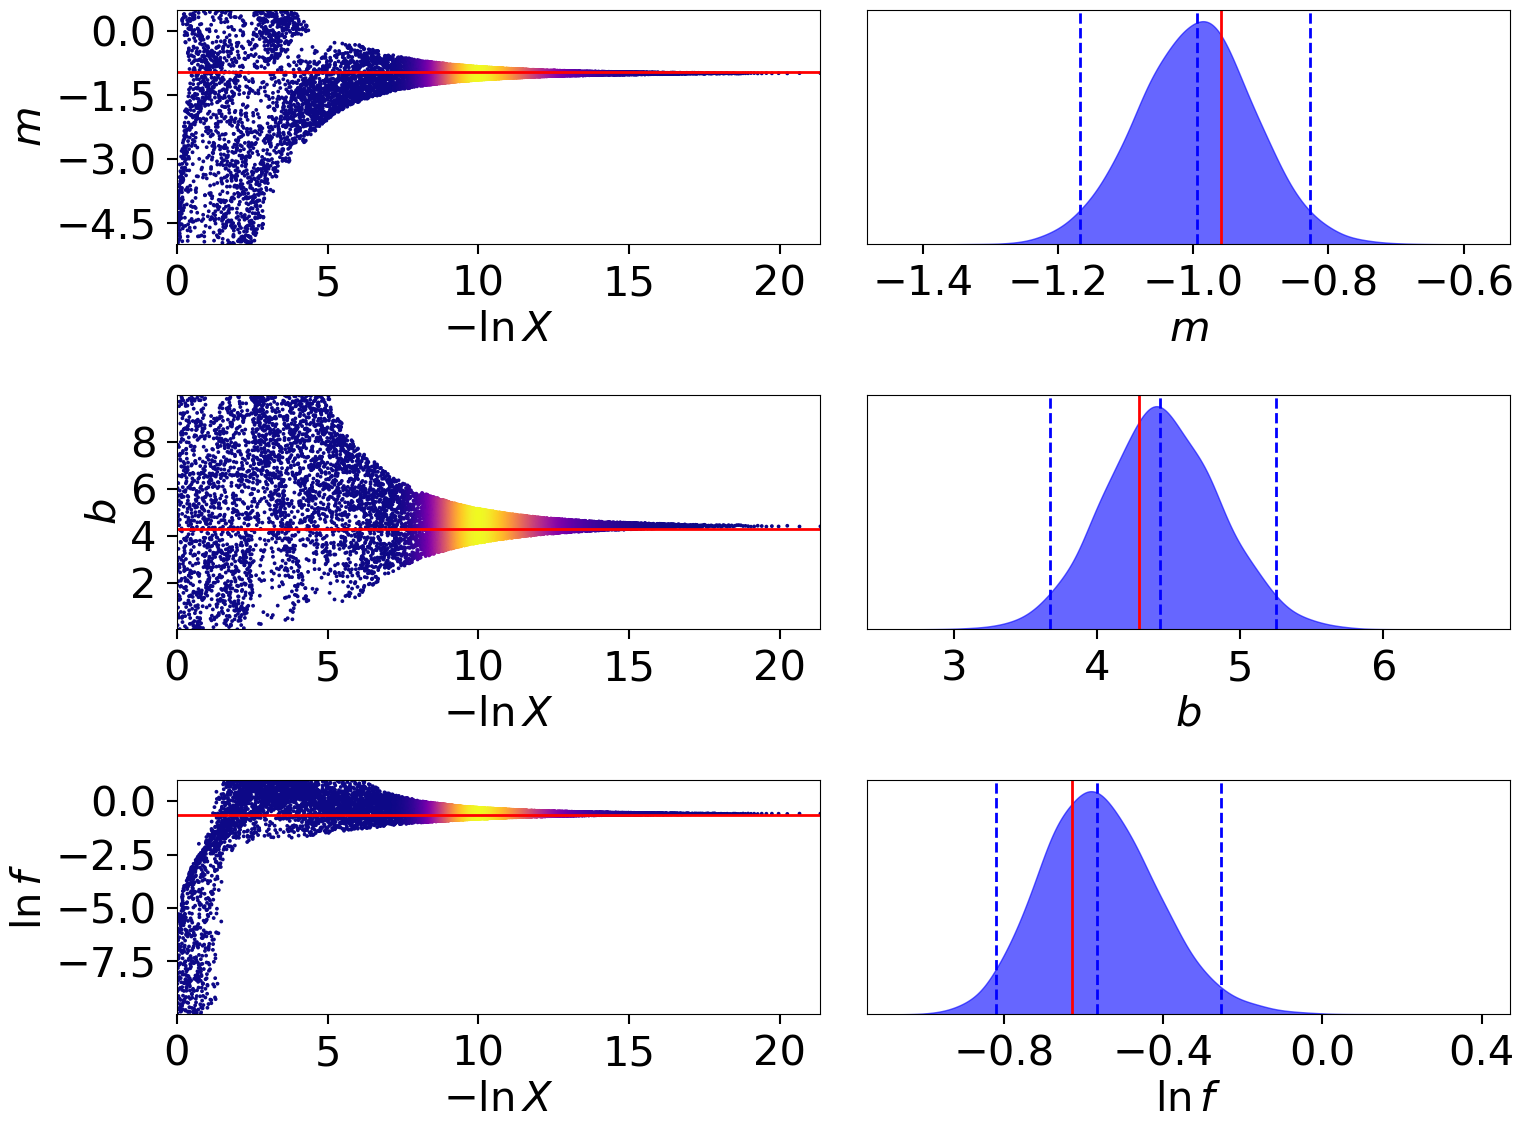

In [34]:
from dynesty import plotting as dyplot

truths = [m_true, b_true, np.log(f_true)]
labels = [r'$m$', r'$b$', r'$\ln f$']
fig, axes = dyplot.traceplot(dsampler.results, truths=truths, labels=labels,
                             fig=plt.subplots(3, 2, figsize=(16, 12)))
fig.tight_layout()

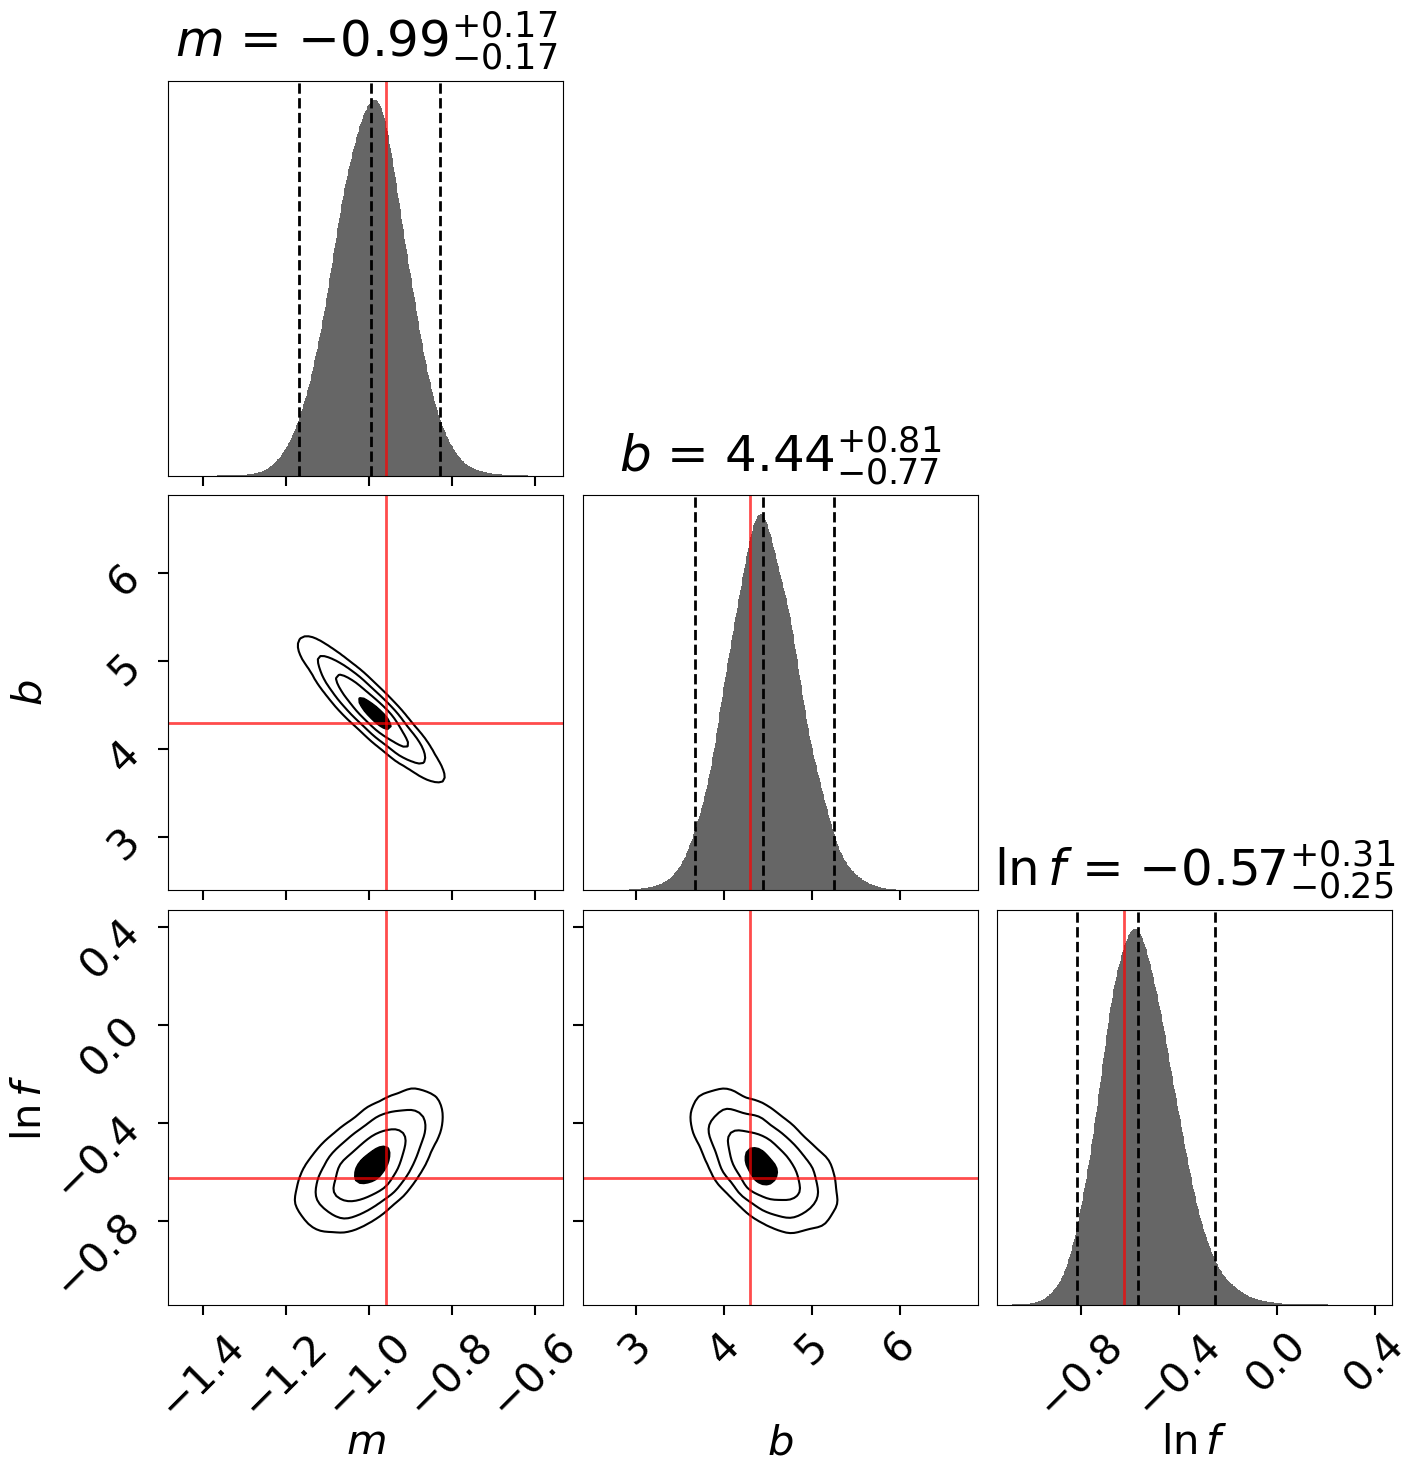

In [35]:
fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(3, 3, figsize=(15, 15)))

# Problem 3: Astrophysics

Select an astrophysical dataset of your choosing. Fit the data using (a) an ensemble sampler, (b) HMC, and (c) Nested Sampling. Verify that the three methods produce equivalent results.